In [1]:
import numpy as np
import pandas as pd
import re
import sys, os
import glob
import gc
import itertools
import zipfile

from tqdm import tqdm
import shutil

from pathlib import Path

here_path = Path().resolve()
repo_path = here_path.parents[2]
sys.path.append(str(repo_path))

#module_path = os.path.abspath(os.path.join('../../'))
#if module_path not in sys.path:
#    sys.path.append(module_path)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from py.utils import verifyDir
from py.datasets.dataprocess.comparisons import EloRatings

In [4]:
geo_level="All"

In [5]:
DATA_PATH = f"{repo_path}/data/pp2/"
CSV_PATH=f"{DATA_PATH}raw/"
PP_IMAGES_PATH=f"{DATA_PATH}images/"

PROCESSED_PATH=f"{DATA_PATH}processed/"
QSCORE_PATH=f"{PROCESSED_PATH}ELOscores/"
GEO_LEVEL_PATH=f"{QSCORE_PATH}{geo_level}/"
RESULTS_PATH=f"{GEO_LEVEL_PATH}Scores/"
IMAGES_PATH=f"{GEO_LEVEL_PATH}Images/"

N_JOBS=8

In [6]:
verifyDir(QSCORE_PATH)
verifyDir(RESULTS_PATH)
verifyDir(IMAGES_PATH)

In [7]:
%%time
pp2_comparisons_df = pd.read_csv(zipfile.ZipFile(f"{PROCESSED_PATH}HumanEvaluations.zip").open("HumanEvaluations/comparisons.csv"), sep=";", low_memory=False)
pp2_comparisons_df

CPU times: user 8 s, sys: 548 ms, total: 8.54 s
Wall time: 8.54 s


,vote_id,left_id,right_id,winner,category,voter_uniqueid,left_lat,left_long,left_city,left_country,left_continent,left_image_path,right_lat,right_long,right_city,right_country,right_continent,right_image_path,sorted_pair,user_id
0,5815426b02a8dc05afdf2b74,50e5f7d4d7c3df413b00056a,50f42c0dfdc9f065f00017bc,left,safety,8f5fe1b8602349f7bdf8a27e5ae75a48,22.310524,114.170637,Hong Kong,China,Asia,Hong Kong/50e5f7d4d7c3df413b00056a.JPG,52.302266,20.989567,Warsaw,Poland,Europe,Warsaw/50f42c0dfdc9f065f00017bc.JPG,"('50e5f7d4d7c3df413b00056a', '50f42c0dfdc9f065...",user_0
1,51f2e453ad93a763cc1d2e9c,50e5f7d4d7c3df413b00056a,50f562ddfdc9f065f0005af3,right,safety,3a666b3c1ca84ccfa0cdd3c7423228f2,22.310524,114.170637,Hong Kong,China,Asia,Hong Kong/50e5f7d4d7c3df413b00056a.JPG,1.285515,103.810072,Singapore,Singapore,Asia,Singapore/50f562ddfdc9f065f0005af3.JPG,"('50e5f7d4d7c3df413b00056a', '50f562ddfdc9f065...",user_1
2,546fd72802a8dc4bc0758a3b,50e5f7d4d7c3df413b00056a,50f5eb24fdc9f065f000804a,right,safety,b544eec9acb74a2f8a7f464560fe6242,22.310524,114.170637,Hong Kong,China,Asia,Hong Kong/50e5f7d4d7c3df413b00056a.JPG,-22.807149,-43.413760,Rio De Janeiro,Brasil,South America,Rio De Janeiro/50f5eb24fdc9f065f000804a.JPG,"('50e5f7d4d7c3df413b00056a', '50f5eb24fdc9f065...",user_2
3,537e474402a8dc0677005191,50e5f7d4d7c3df413b00056a,50f5eb4afdc9f065f00081bb,equal,beautiful,2035397a7a80404ab026246c9e42d991,22.310524,114.170637,Hong Kong,China,Asia,Hong Kong/50e5f7d4d7c3df413b00056a.JPG,-22.805310,-43.427501,Rio De Janeiro,Brasil,South America,Rio De Janeiro/50f5eb4afdc9f065f00081bb.JPG,"('50e5f7d4d7c3df413b00056a', '50f5eb4afdc9f065...",user_3
4,523376dead93a760f8daa56b,50e5f7d4d7c3df413b00056a,513cbda1fdc9f035870010d9,left,safety,42e405acdb5f439a94f37df2121f0b1a,22.310524,114.170637,Hong Kong,China,Asia,Hong Kong/50e5f7d4d7c3df413b00056a.JPG,29.838246,-95.312139,Houston,USA,North America,Houston/513cbda1fdc9f035870010d9.JPG,"('50e5f7d4d7c3df413b00056a', '513cbda1fdc9f035...",user_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555543,51f80ed7ad93a780c8788fc6,5185cd21fdc9f03fd5000cdf,513e6465fdc9f0358700b812,left,wealthy,eb9cb07d831a4888898ee8eb8649b52f,45.479466,-73.662663,Montreal,Canada,North America,Montreal/5185d53bfdc9f03fd5001493.JPG,35.058854,135.756810,Kyoto,Japan,Asia,Kyoto/513e6465fdc9f0358700b812.JPG,"('513e6465fdc9f0358700b812', '5185cd21fdc9f03f...",user_3390
1555544,592c770302a8dc05afdfa4f3,5185cd21fdc9f03fd5000cdf,513e6c96fdc9f0358700c1ac,left,safety,479c83d12ecd4c2db4cc46c56bc353b3,45.479466,-73.662663,Montreal,Canada,North America,Montreal/5185d53bfdc9f03fd5001493.JPG,35.594405,139.765548,Tokyo,Japan,Asia,Tokyo/513e6c96fdc9f0358700c1ac.JPG,"('513e6c96fdc9f0358700c1ac', '5185cd21fdc9f03f...",user_94573
1555545,543e49d002a8dc4bbe75863a,5185cd21fdc9f03fd5000cdf,51408cabfdc9f0358700eb8a,right,lively,cf6fd73f3bab40c597ad5d57f24ea025,45.479466,-73.662663,Montreal,Canada,North America,Montreal/5185d53bfdc9f03fd5001493.JPG,38.760147,-9.105329,Lisbon,Portugal,Europe,Lisbon/51408cabfdc9f0358700eb8a.JPG,"('51408cabfdc9f0358700eb8a', '5185cd21fdc9f03f...",user_4313
1555546,586ba57302a8dc05afdf5c3b,5185cd21fdc9f03fd5000cdf,51409d77fdc9f049260012ff,left,safety,8459e27a9f104cf19d84a3d1bb9d8971,45.479466,-73.662663,Montreal,Canada,North America,Montreal/5185d53bfdc9f03fd5001493.JPG,41.913943,12.425267,Rome,Italy,Europe,Rome/51409d77fdc9f049260012ff.JPG,"('51409d77fdc9f049260012ff', '5185cd21fdc9f03f...",user_28625


### Initialize ELO-Ratings calculator

In [8]:
pp = EloRatings(pp2_comparisons_df, place_level=geo_level)

In [9]:
metrics = pp.get_metrics()
metrics

array(['safety', 'beautiful', 'wealthy', 'lively', 'boring', 'depressing'],
      dtype=object)

#### Calculating Elo-Rating per image

Time: aprox 35 seg

In [10]:
%%time
images_metric = {"metrics":[], "values":[]}
summary_df = pd.DataFrame()
for metric in metrics:
    verifyDir(f"{RESULTS_PATH}{metric}/")
    
    if Path(f"{RESULTS_PATH}{metric}/ratings.csv").exists():
        ratings_df = pd.read_csv(f"{RESULTS_PATH}{metric}/ratings.csv", sep=";", low_memory=False)
    else:
        pp.calculate_elo_ratings(metric=metric, initial_rating=0, K=100, adaptative_K=False)
        pp.normalize_elo_ratings()
        ratings_df = pp.get_elo_ratings()
        ratings_df.to_csv(f"{RESULTS_PATH}{metric}/ratings.csv", sep=";", index=False)
        print(f"Saving {metric} in {RESULTS_PATH}{metric}/ratings.csv")
    
    images_metric["metrics"].append(metric)
    images_metric["values"].append(ratings_df.shape[0])
    
    if len(summary_df)==0:
        summary_df = ratings_df[["image_id", "lat", "long", "city", "country", "continent", "EloRating", "EloScore"]].copy()
    else:
        summ_ = ratings_df[["image_id", "lat", "long", "city", "country", "continent", "EloRating", "EloScore"]].copy()
        summary_df = pd.merge(summary_df, summ_, how="outer", on=["image_id", "lat", "long", "city", "country", "continent"])
    summary_df.rename(columns={"EloRating": f"{metric}_EloRating", "EloScore": f"{metric}"}, inplace=True)
    
summary_df.fillna(0., inplace=True)

CPU times: user 1.08 s, sys: 58.9 ms, total: 1.14 s
Wall time: 1.14 s


#### Adding image paths

In [11]:
base_path = Path(PP_IMAGES_PATH)
img_path_list = np.sort([str(p.relative_to(base_path)) for p in base_path.glob('*/*.JPG')])
image_path_dict = {path.split("/")[-1].replace(".JPG",""): path for path in img_path_list}

In [12]:
%%time
summary_df["image_path"] = summary_df["image_id"].map(image_path_dict)
summary_df = summary_df[~summary_df["image_path"].isna()].copy()
summary_df

CPU times: user 43.8 ms, sys: 0 ns, total: 43.8 ms
Wall time: 43 ms


,image_id,lat,long,city,country,continent,safety_EloRating,safety,beautiful_EloRating,beautiful,wealthy_EloRating,wealthy,lively_EloRating,lively,boring_EloRating,boring,depressing_EloRating,depressing,image_path
0,50e5f7d4d7c3df413b00056a,22.310524,114.170637,Hong Kong,China,Asia,-8.944222,4.843530,-140.875715,3.247608,-129.800278,2.995772,-0.498412,4.928996,-7.146312,4.897918,0.000000,0.000000,Hong Kong/50e5f7d4d7c3df413b00056a.JPG
1,50e5f7d4d7c3df413b00056b,22.274799,114.192828,Hong Kong,China,Asia,-60.901558,4.264056,-131.807586,3.371634,-29.800278,4.385305,-24.218534,4.629905,50.000000,5.786344,0.000000,5.279713,Hong Kong/50e5f7d4d7c3df413b00056b.JPG
2,50e5f7d4d7c3df413b00056c,22.291117,114.147373,Hong Kong,China,Asia,-30.445414,4.603730,-0.830063,5.163023,0.000000,4.799390,-139.656968,3.174322,-29.800278,4.545727,0.000000,0.000000,Hong Kong/50e5f7d4d7c3df413b00056c.JPG
3,50e5f7d4d7c3df413b00056d,22.314273,114.177176,Hong Kong,China,Asia,54.258519,5.548423,0.000000,5.174376,-28.747572,4.399933,0.000000,4.935280,50.000000,5.786344,-52.913469,4.601608,Hong Kong/50e5f7d4d7c3df413b00056d.JPG
4,50e5f7d4d7c3df413b00056e,22.332412,114.204790,Hong Kong,China,Asia,-201.856927,2.691997,-129.800278,3.399088,18.721773,5.059535,-97.573952,3.704954,-92.853688,3.565466,-7.146312,5.188130,Hong Kong/50e5f7d4d7c3df413b00056e.JPG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108815,5185d533fdc9f03fd500148d,45.635489,-73.514755,Montreal,Canada,North America,17.307878,5.136317,14.460582,5.372154,-118.975467,3.146187,-255.914575,1.708409,-20.104497,4.696463,67.379051,6.143199,Montreal/5185d533fdc9f03fd500148d.JPG
108816,5185d533fdc9f03fd500148e,45.581265,-73.511511,Montreal,Canada,North America,-31.152872,4.595840,-138.761918,3.276519,-68.783928,3.843615,-194.771196,2.479377,9.586073,5.158048,46.208681,5.871893,Montreal/5185d533fdc9f03fd500148e.JPG
108817,5185d534fdc9f03fd500148f,45.591299,-73.520681,Montreal,Canada,North America,98.812508,6.045328,64.130222,6.051489,46.421437,5.444431,30.340326,5.317847,25.165718,5.400258,-98.887463,4.012435,Montreal/5185d534fdc9f03fd500148f.JPG
108818,5185d534fdc9f03fd5001490,45.470656,-73.631901,Montreal,Canada,North America,-42.106932,4.473670,-5.047147,5.105345,47.978388,5.466066,4.014174,4.985896,7.324766,5.122893,-103.701484,3.950742,Montreal/5185d534fdc9f03fd5001490.JPG


In [13]:
summary_df.to_csv(f"{RESULTS_PATH}scores.csv", sep=";", index=False)

### Statistics

#### Correlation matrix

In [14]:
# df = data_df[data_df["city"]=="Hong Kong"].copy()
# df = data_df[data_df["city"]=="Mexico City"].copy()
# df = data_df[data_df["city"]=="Gaborone"].copy()
# df = data_df[data_df["city"]=="Helsinki"].copy()

In [15]:
correlation_matrix = summary_df.loc[:, ["safety", "beautiful", "wealthy", "lively", "boring", "depressing"]].corr()
correlation_matrix

,safety,beautiful,wealthy,lively,boring,depressing
safety,1.000000,0.306591,0.262984,0.287723,-0.103559,-0.167079
beautiful,0.306591,1.000000,0.208049,0.179824,-0.084782,-0.152412
wealthy,0.262984,0.208049,1.000000,0.188610,-0.071568,-0.116820
lively,0.287723,0.179824,0.188610,1.000000,-0.131223,-0.119733
boring,-0.103559,-0.084782,-0.071568,-0.131223,1.000000,0.059808
depressing,-0.167079,-0.152412,-0.116820,-0.119733,0.059808,1.000000


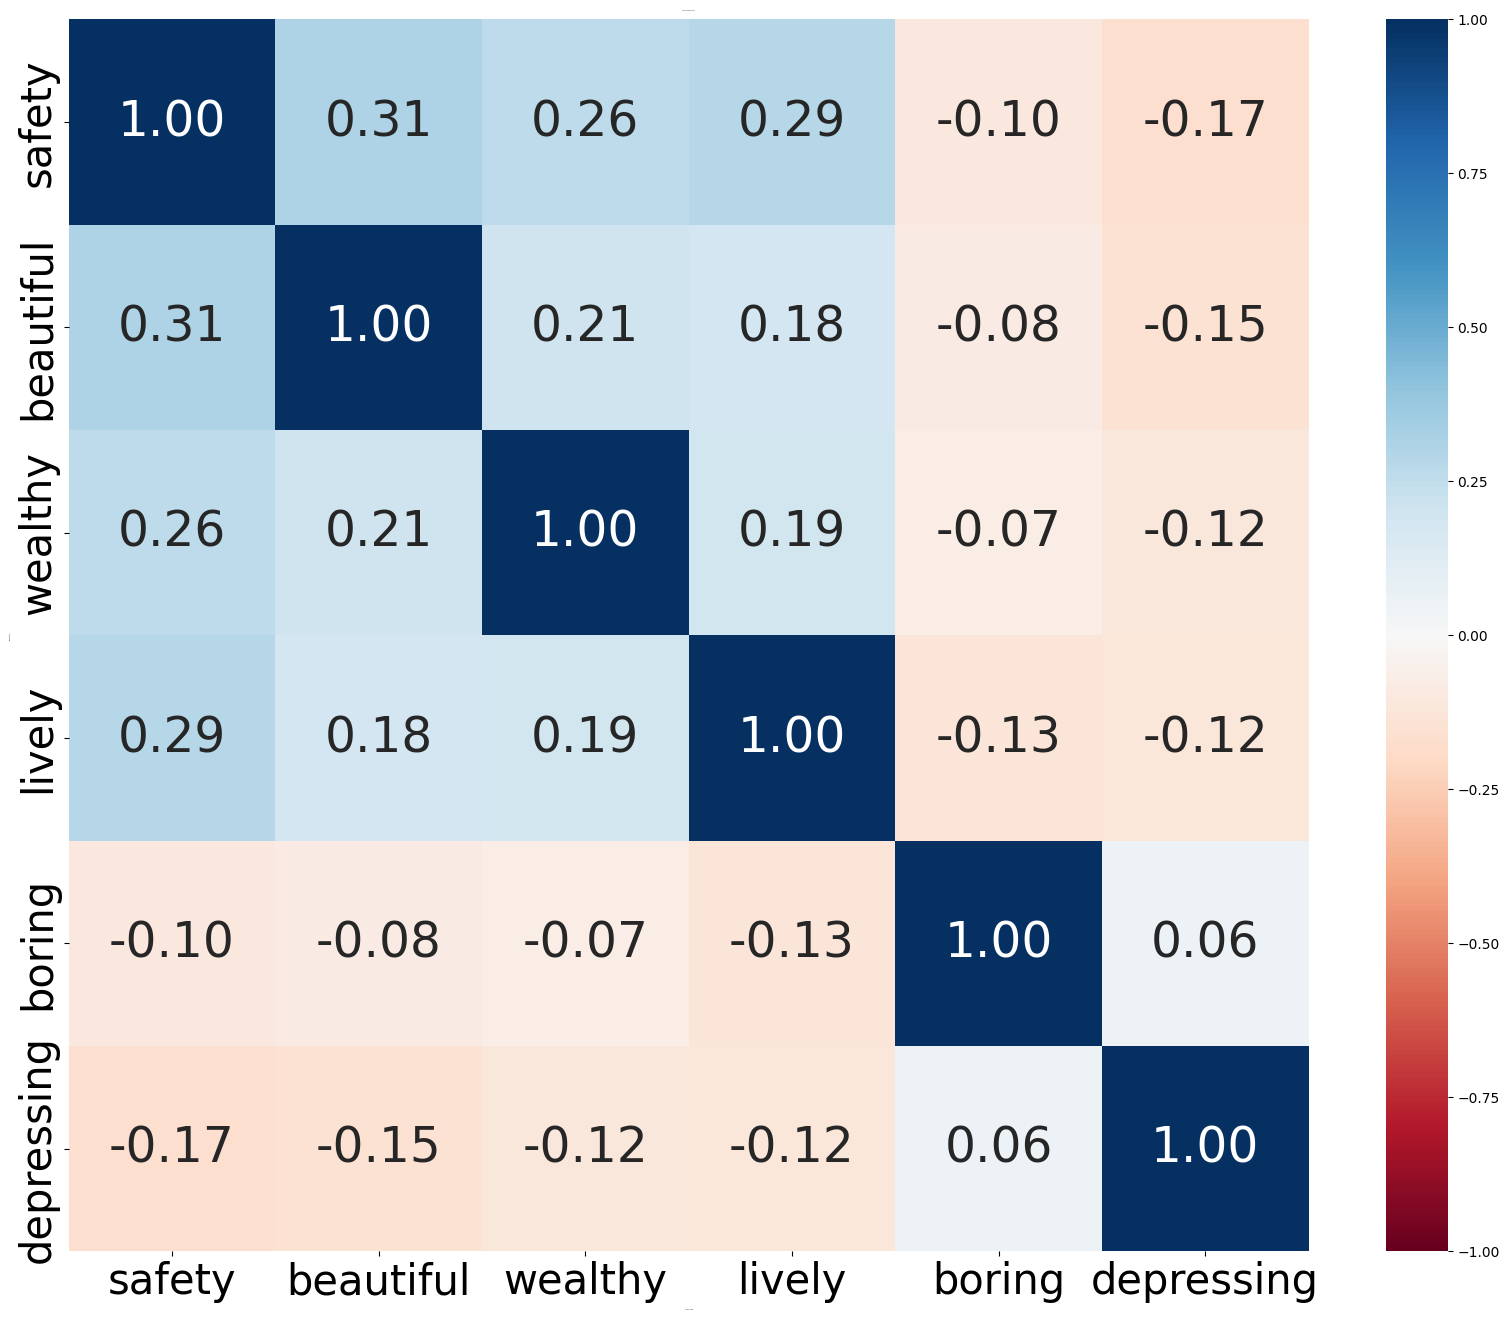

In [16]:
# confusion_matrix = pd.crosstab(data_df['annotations'], data_df['crimetype'], rownames=['annotations'], colnames=['crimetype'])

cmap=sns.diverging_palette(130, 700, s=100, as_cmap=True)
cmap="RdBu"

plt.figure(figsize=(20, 16))
sns_heatmap = sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap=cmap, center=0, vmin=-1, vmax=1, cbar=True, annot_kws={"size": 35})

# Customize the plot
sns_heatmap.set_title('Correlation Matrix', fontsize=0)
sns_heatmap.set_xlabel('Crime type', fontsize=0, rotation=0)
sns_heatmap.set_ylabel('Annotations', fontsize=0)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# Display the plot
plt.show()

#### Aggregate information

In [17]:
aggregate_mean_df = pd.pivot_table(summary_df,
                      index=["city", "country", "continent"],
                      values=["image_id", "safety", "beautiful", "wealthy", "lively", "boring", "depressing"],
                      aggfunc = {
                          "image_id": len,
                          "safety": "mean",
                          "beautiful": "mean",
                          "wealthy": "mean",
                          "lively": "mean",
                          "boring": "mean",
                          "depressing": "mean",
                      }).rename(columns={"image_id": "num_images"}).reset_index().set_index(["city", "country", "continent", "num_images"])
aggregate_mean_df.columns = [ f"{c}_mean" for c in aggregate_mean_df.columns ]

aggregate_std_df = pd.pivot_table(summary_df,
                      index=["city", "country", "continent"],
                      values=["image_id", "safety", "beautiful", "wealthy", "lively", "boring", "depressing"],
                      aggfunc = {
                          "image_id": len,
                          "safety": "std",
                          "beautiful": "std",
                          "wealthy": "std",
                          "lively": "std",
                          "boring": "std",
                          "depressing": "std",
                      }).rename(columns={"image_id": "num_images"}).reset_index().set_index(["city", "country", "continent", "num_images"])
aggregate_std_df.columns = [ f"{c}_std" for c in aggregate_std_df.columns ]

aggregate_df = pd.merge(aggregate_mean_df, aggregate_std_df, on=["city", "country", "continent", "num_images"])
aggregate_df.reset_index(inplace=True)

new_columns = ["city", "country", "continent", "num_images"]
for metric in metrics:
    new_columns.append(f"{metric}_mean")
    new_columns.append(f"{metric}_std")

aggregate_df = aggregate_df[new_columns].copy()
aggregate_df.to_csv(f"{RESULTS_PATH}aggregate_statistics.csv", sep=";", index=False)

##### Score histogram per category

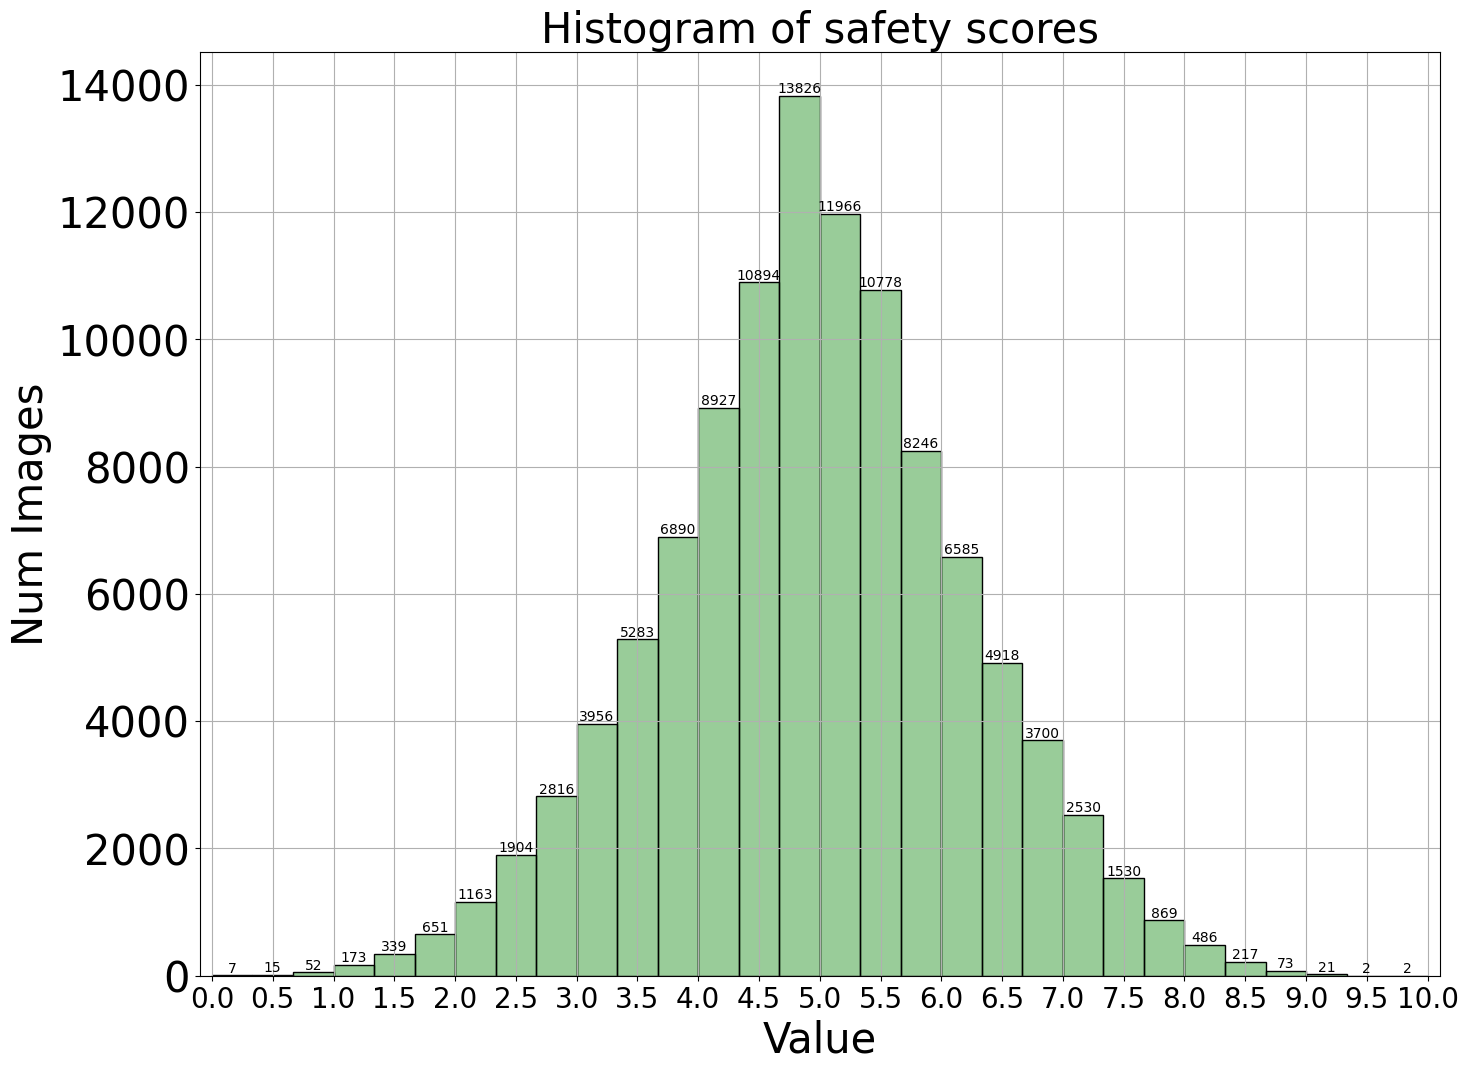

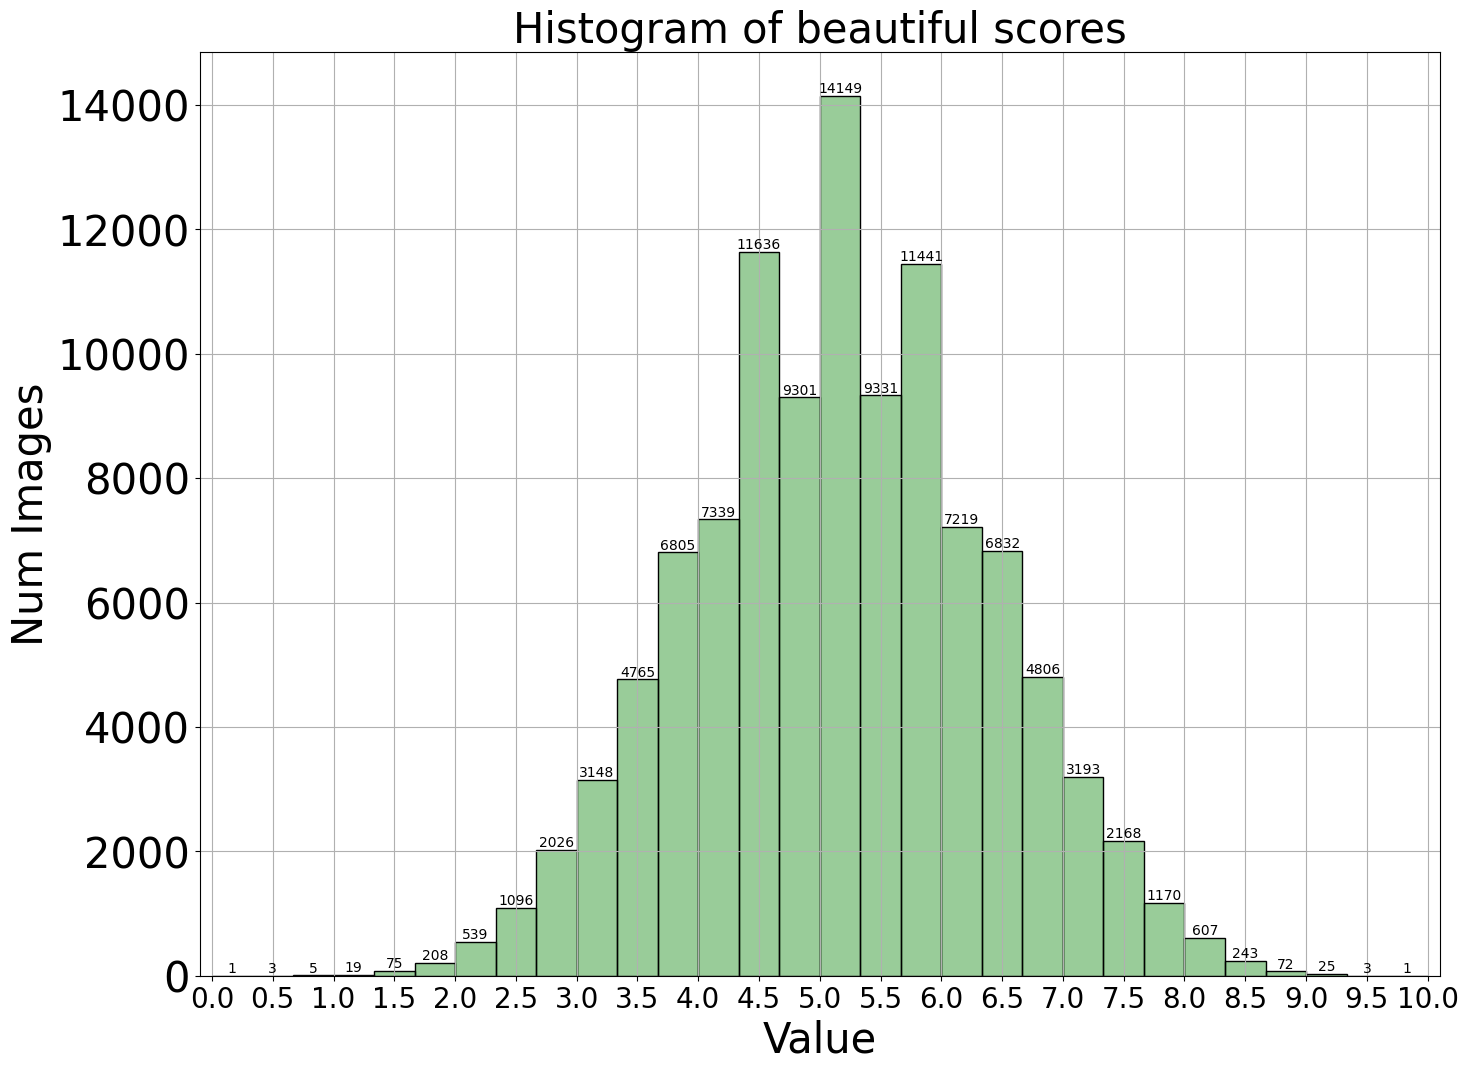

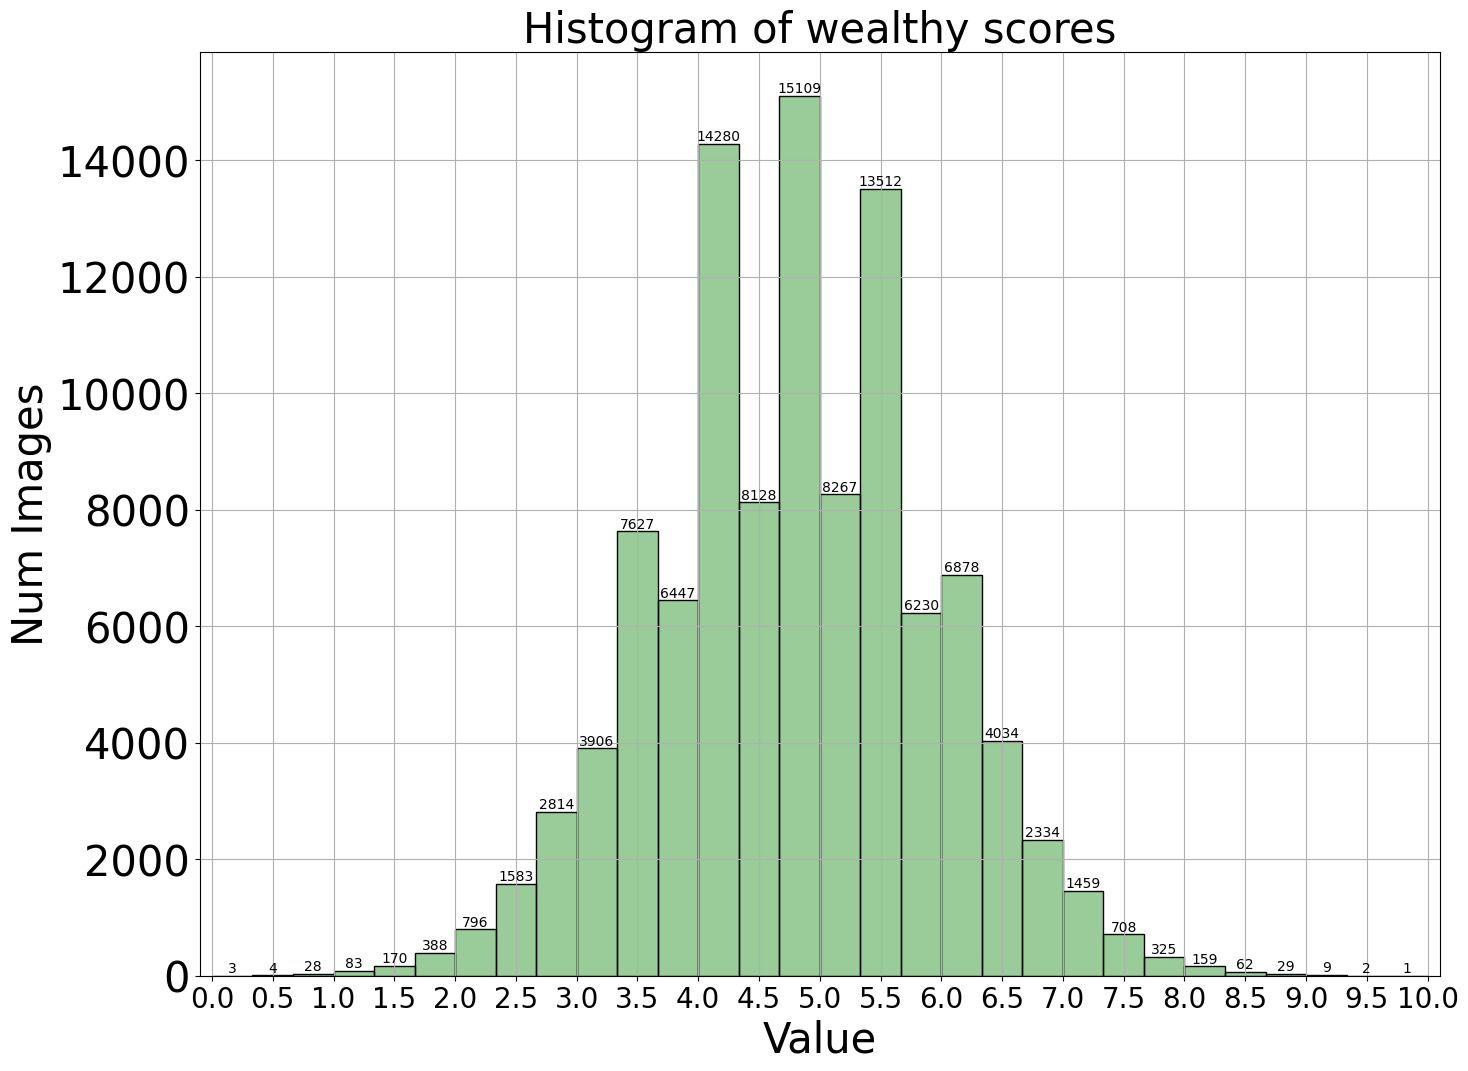

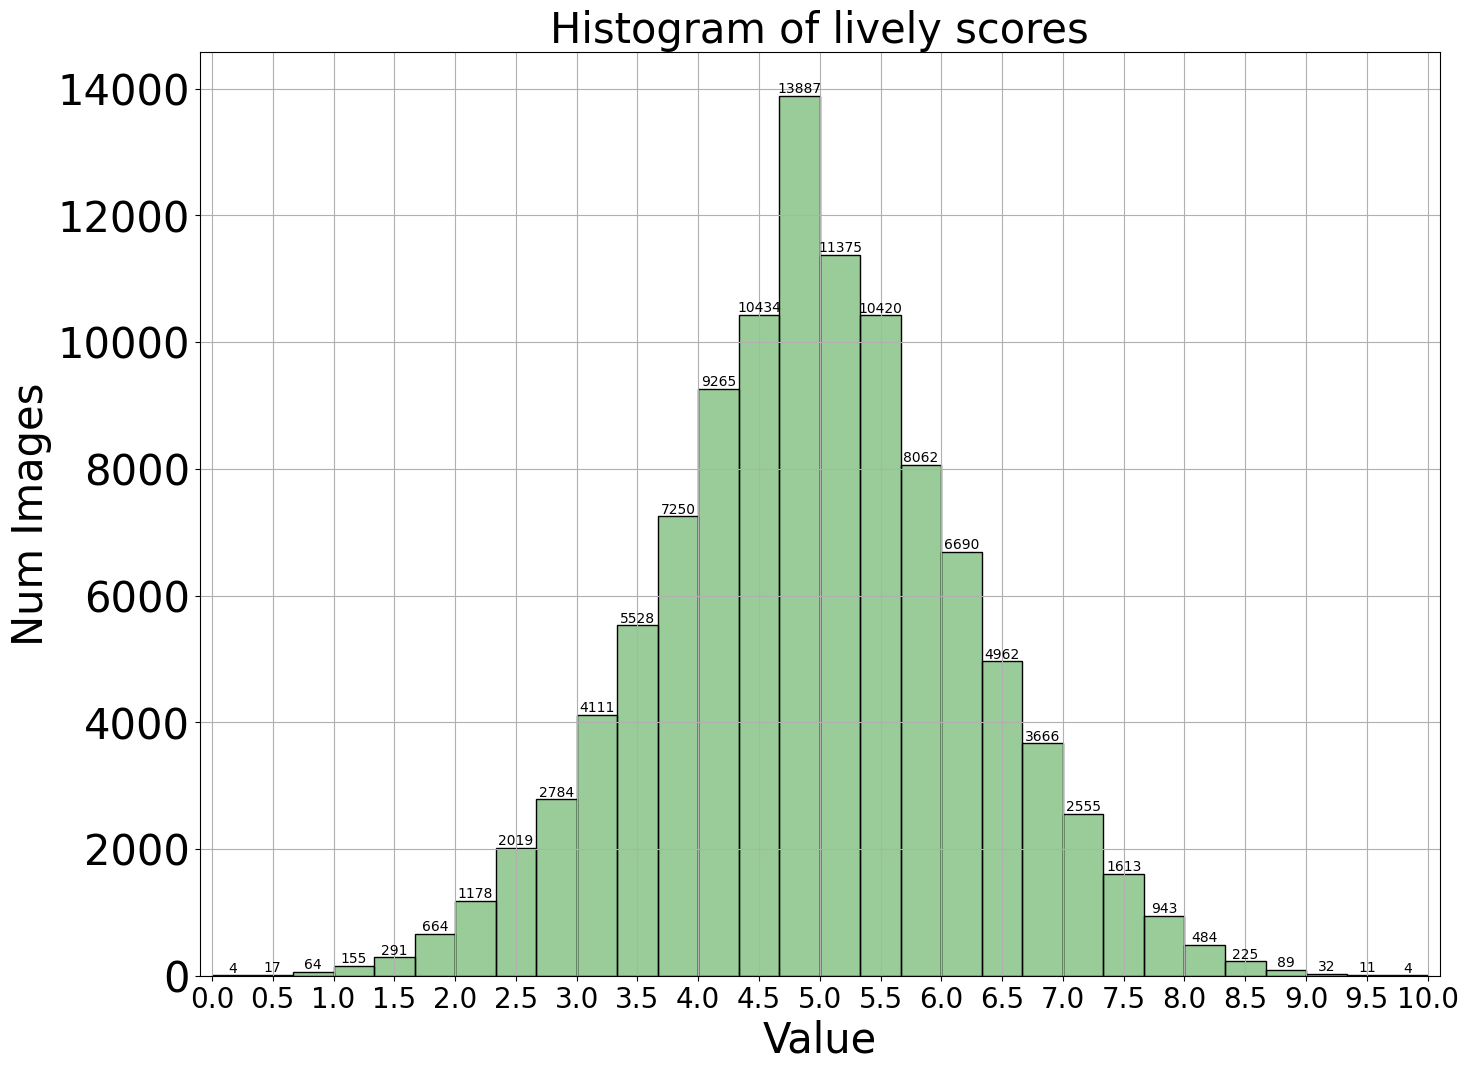

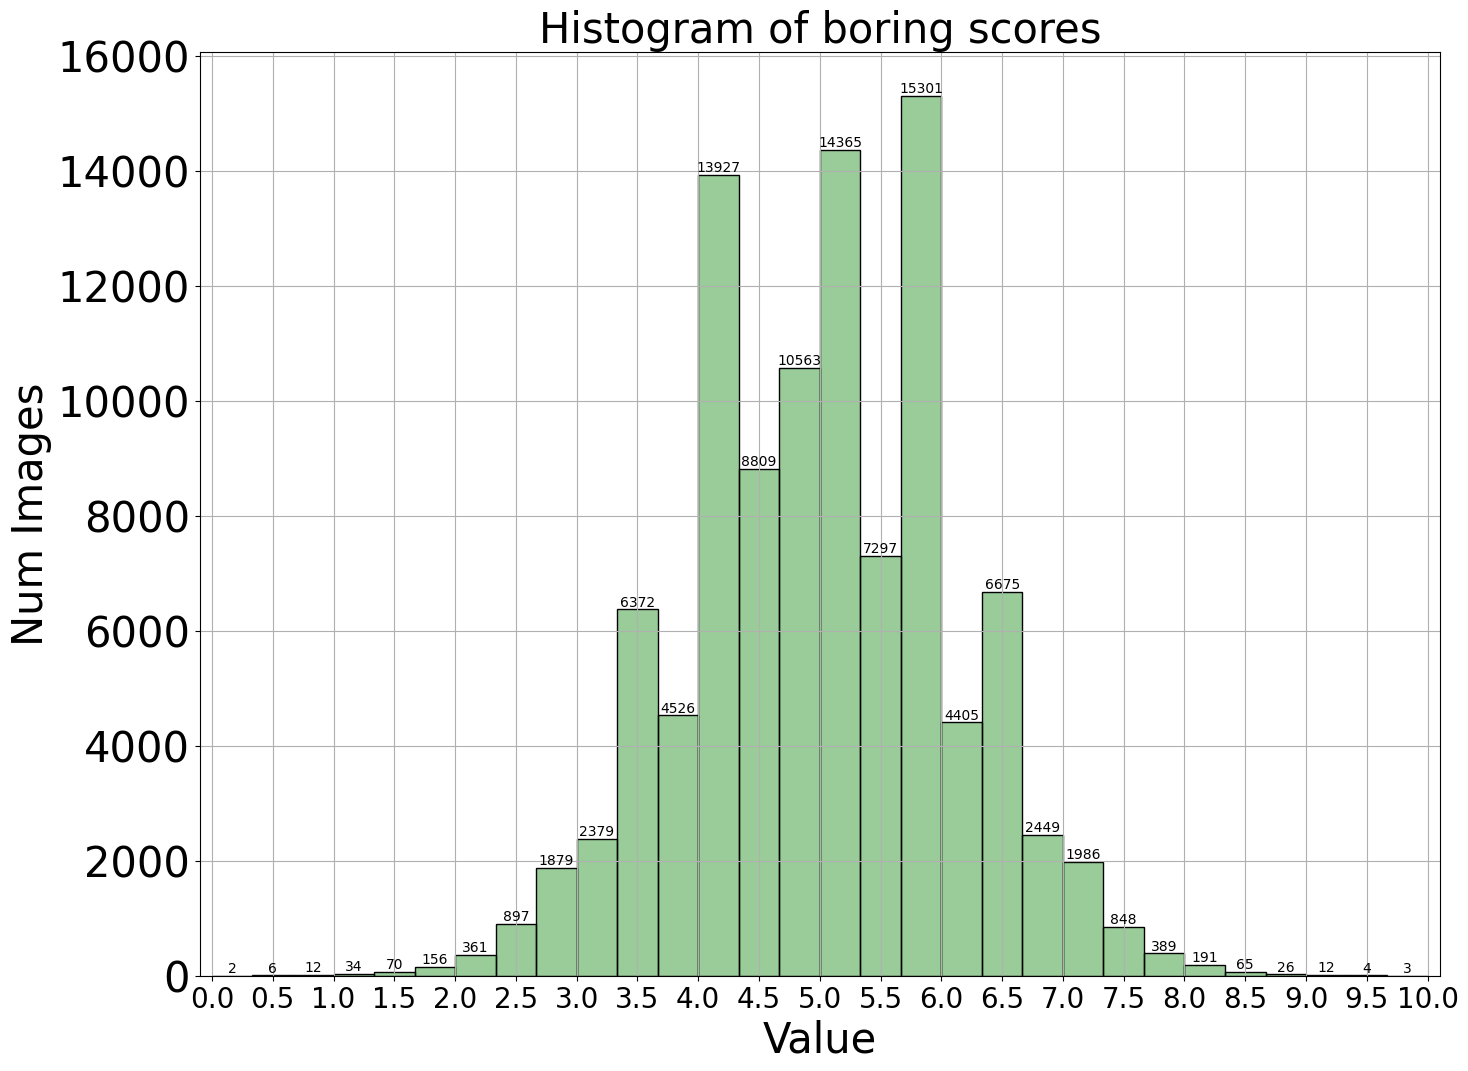

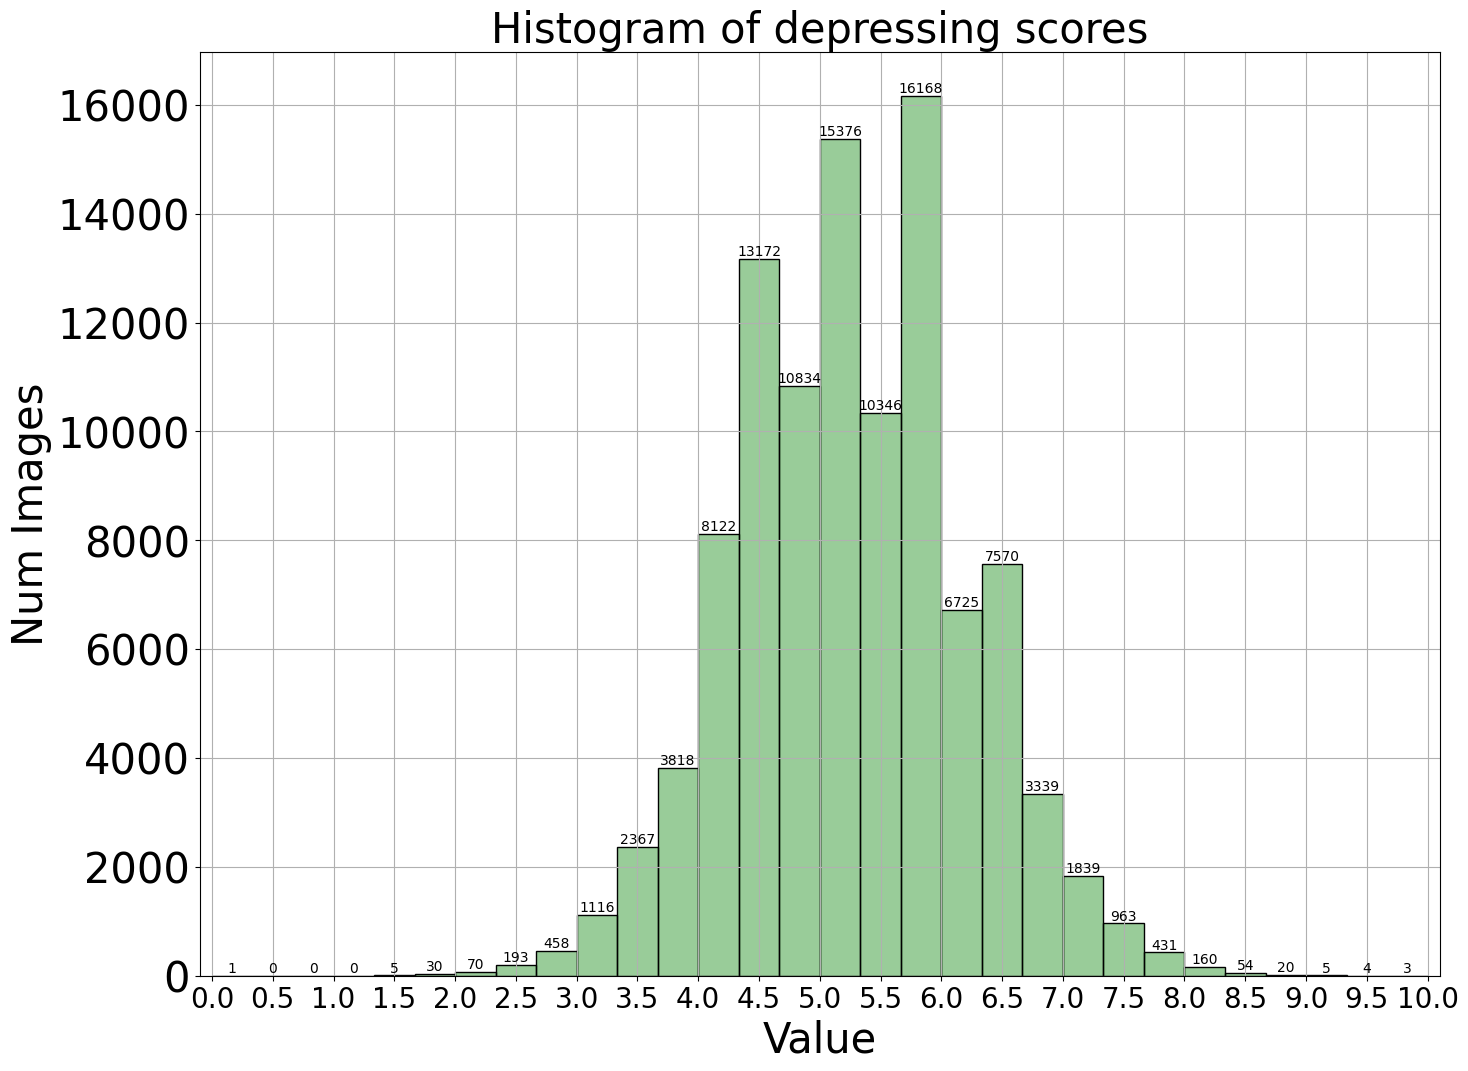

In [18]:
for metric in metrics:
    verifyDir(f"{IMAGES_PATH}{metric}/")
    
    fig, ax = plt.subplots(figsize=(16,12), nrows=1, ncols=1, sharex=False, sharey=False)

    scores_df = pd.read_csv(f"{RESULTS_PATH}{metric}/ratings.csv", sep=";", low_memory=False)
    scores = scores_df["EloScore"].values

    sns_fig = sns.histplot(scores, 
                             bins=30, 
                             color='g', 
                             kde=False, 
                             label='City', 
                             ax=ax,
                             alpha=0.4)

    sns_fig.set_title(f"Histogram of {metric} scores", fontsize=30)
    sns_fig.set_ylabel('Num Images', fontsize=30)
    sns_fig.set_xlabel('Value', fontsize=30)

    # rotate the axis ticklabels
    _ = sns_fig.tick_params(axis='x', rotation=0, labelsize=20)

    # rotate the axis ticklabels
    _ = sns_fig.tick_params(axis='y', labelsize=30)

    # add annotation
    _ = sns_fig.bar_label(sns_fig.containers[0], fmt='%0.0f', fontsize=10,rotation=0)

    # add a space on y for the annotations
    #sns_fig.margins(x=0.1)
    ax.grid(True)

    # plt.xlim(-0.1, 10.1)
    # plt.xticks(np.arange(0.0, 10.1, 0.5))

    # ax.legend(fontsize=40)
    # a,b = ax.get_xlim()
    xticks = np.arange(0.0, 10.1, 0.5)  # Adjust the range and step as needed
    sns_fig.set_xticks(xticks)
    ax.set_xlim(-0.1, 10.1)

    # # Display the plot
    # plt.legend()

    fig.savefig(f'{IMAGES_PATH}/{metric}/score_distribution.png')
    plt.show()

##### Score histogram per category and cities

In [19]:
for metric in metrics:
    verifyDir(f"{IMAGES_PATH}{metric}/cities/")
    verifyDir(f"{RESULTS_PATH}{metric}/cities/")
    
    scores_df = pd.read_csv(f"{RESULTS_PATH}{metric}/ratings.csv", sep=";", low_memory=False)
    
    for current_city in scores_df["city"].unique().tolist():
        city_df = scores_df[scores_df["city"]==current_city].copy()
        city_df.to_csv(f"{RESULTS_PATH}/{metric}/cities/{current_city}.csv", sep=";", index=False)
        
        scores = city_df["EloScore"].values
        
        fig, ax = plt.subplots(figsize=(16,12), nrows=1, ncols=1, sharex=False, sharey=False)
        
        sns_fig = sns.histplot(scores, 
                                 bins=30, 
                                 color='g', 
                                 kde=False, 
                                 label='City', 
                                 ax=ax,
                                 alpha=0.4)

        sns_fig.set_title(f"Histogram of {metric} scores in {current_city}", fontsize=30)
        sns_fig.set_ylabel('Num Images', fontsize=20)
        sns_fig.set_xlabel('Value', fontsize=20)

        # rotate the axis ticklabels
        _ = sns_fig.tick_params(axis='x', rotation=0, labelsize=20)

        # rotate the axis ticklabels
        _ = sns_fig.tick_params(axis='y', labelsize=20)

        # add annotation
        _ = sns_fig.bar_label(sns_fig.containers[0], fmt='%0.0f', fontsize=10,rotation=0)

        # add a space on y for the annotations
        #sns_fig.margins(x=0.1)
        ax.grid(True)

        # plt.xlim(-0.1, 10.1)
        # plt.xticks(np.arange(0.0, 10.1, 0.5))

        # ax.legend(fontsize=40)
        # a,b = ax.get_xlim()
        xticks = np.arange(0.0, 10.1, 0.5)  # Adjust the range and step as needed
        sns_fig.set_xticks(xticks)
        ax.set_xlim(-0.1, 10.1)

        # # Display the plot
        # plt.legend()

        fig.savefig(f'{IMAGES_PATH}/{metric}/cities/{current_city}_score_distribution.png')
        plt.close(fig)
#         plt.show()
